# Part of speech clustering

Here we evaluate how well a particular clustering captures aspects of the text by using "aspect patterns" in the form of regular expressions that flag passages related to a particular aspect (which could be a topic, applicatioon domain, semantic framework, etc.). Clusterings that capture an aspect well will concentrate instances of that aspect in a smaller number of clusters than those that do not capture the aspect well, in which the aspect instances ahould be more randomly distrubuted. We use entropy metrics to quantify the degree of concentration of the aspect pattern across the clusters.

In [42]:
import regex, math, os, sys
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('misc/')
from utils import utils

POS_CLUSTER_FILE = "../../data/dolly_pos_clusters.parquet"

In [43]:
# Patterns are the same ones used in "Aspect-aware semantic clustering".

from text_patterns import patterns

Note that the 'alternatives' pattern was discovered by POS n-gram clustering, so we expect that it may be more concentrated in the POS clusters than in other clusterings.

In [35]:
pos_data = pd.read_parquet(POS_CLUSTER_FILE, engine='pyarrow')

pos_data

,instruction,context,response,category,has_context,instruction_vector,response_vector,instruction_A,instruction_B,response_A,response_B,instruction_pos,pos_tfidf_PCs,pos__A,pos__B,pos__C,pos__D,pos__E,pos__F
357,Who are N-Dubz?,,N-Dubz are a popular band in the United Kingdo...,open_qa,False,"[-0.3019573390483856, 0.14654117822647095, -0....","[-0.3551376760005951, -0.15036641061306, -0.25...",inst_A16,inst_B76,resp_A02,resp_B02,pron aux propn noun propn punct,"[-0.013507235393393371, -0.010853551043372801,...",pos__A1,pos__B01,pos__C001,pos__D001,pos__E001,pos__F0001
7725,What is Bubble tea?,"Bubble tea (also known as pearl milk tea, bubb...",Boba tea is a very delicious drink originally ...,closed_qa,True,"[-0.5753342509269714, -0.5540406107902527, 0.0...","[-0.44564568996429443, -0.3017743229866028, -0...",inst_A18,inst_B86,resp_A05,resp_B13,pron aux propn noun punct,"[-0.013507235393393371, -0.010853551043372801,...",pos__A1,pos__B01,pos__C001,pos__D001,pos__E001,pos__F0001
13700,What is Palmitic acid?,,Palmitic acid (hexadecanoic acid in IUPAC nome...,open_qa,False,"[-0.19733576476573944, 0.04824097454547882, -0...","[-0.18773141503334045, 0.11972067505121231, -0...",inst_A11,inst_B49,resp_A05,resp_B14,pron aux propn noun punct,"[-0.013507235393393371, -0.010853551043372801,...",pos__A1,pos__B01,pos__C001,pos__D001,pos__E001,pos__F0001
12064,What is Detroit style pizza?,,Detroit pizza is cooked in a square or rectang...,open_qa,False,"[-0.6088963150978088, 0.4358474612236023, -0.3...","[-0.19007514417171478, 0.11616180837154388, -0...",inst_A15,inst_B75,resp_A05,resp_B16,pron aux propn noun noun punct,"[-0.014276154836046514, -0.011972750307702024,...",pos__A1,pos__B01,pos__C001,pos__D001,pos__E001,pos__F0001
13369,What is Cincinnati style chili?,Cincinnati chili (or Cincinnati-style chili) i...,Cincinnati chili is a cinnamon and nutmeg flav...,information_extraction,True,"[-0.588937520980835, 0.2513643801212311, -0.02...","[-0.2475849688053131, -0.01587958261370659, -0...",inst_A15,inst_B75,resp_A05,resp_B16,pron aux propn noun noun punct,"[-0.014276154836046514, -0.011972750307702024,...",pos__A1,pos__B01,pos__C001,pos__D001,pos__E001,pos__F0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4412,"From the given passage, write down some intere...",Butterflies (Rhopalocera) are insects that hav...,1. Butterflies (Rhopalocera) are insects that ...,summarization,True,"[-0.20711590349674225, 0.24547944962978363, 0....","[-0.0876651331782341, -0.13132433593273163, -0...",inst_A12,inst_B54,resp_A03,resp_B09,adp det verb noun punct verb adp det adj noun ...,"[-0.022108387451053584, -0.033231101737593666,...",pos__A9,pos__B74,pos__C126,pos__D233,pos__E579,pos__F1524
9186,Extract the Greek terms in the following parag...,"Meno (/ˈmiːnoʊ/; Greek: Μένων, Ménōn) is a Soc...","- arete: virtues in general, i.e. instead of a...",information_extraction,True,"[-0.1719730645418167, 0.5094059705734253, 0.30...","[0.19114284217357635, 0.30143487453460693, 0.2...",inst_A03,inst_B10,resp_A11,resp_B42,verb det adj noun adp det verb noun punct adp ...,"[-0.029662517322532906, -0.0453240706387447, -...",pos__A9,pos__B74,pos__C126,pos__D233,pos__E579,pos__F1524
3285,"From the following article, tell me the inform...","Austria, formally the Republic of Austria, is ...","The most recent year is 2021, the year Austria...",information_extraction,True,"[-0.08929754793643951, 0.11915569752454758, 0....","[0.11680413782596588, 0.24178341031074524, -0....",inst_A09,inst_B40,resp_A14,resp_B52,adp det verb noun punct verb pron det noun ver...,"[-0.026170891457593996, -0.0388445248574967, -...",pos__A9,pos__B74,pos__C126,pos__D233,pos__E579,pos__F1524
10375,Extract all unique clubs Suyash played for fro...,"Suyash Prabhudessai (born 6 December 1997), is...",* Goa\n* Royal Challengers Bangalore,information_extraction,True,"[0.04713539779186249, 0.28112584352493286, -0....","[0.3706468343734741, -0.2618262767791748, -0.4...",

In [22]:
# # TEMP
# SENTENCE_TRANSFORMER_MODEL_NAME = 'all-MiniLM-L6-v2'
# dolly_data = pd.read_parquet(f'dolly_data_{SENTENCE_TRANSFORMER_MODEL_NAME}.parquet')
# len(dolly_data)

# find patterns in instructions
# df = pos_data.copy()
# text_col = 'instruction'
# for pattern_name in patterns:
#     flag_vector = [bool(regex.search(patterns[pattern_name], sent, regex.IGNORECASE)) for sent in df[text_col]]
#     print(pattern_name, sum(flag_vector))
    # df[f"{pattern_name}_flag"] = flag_vector

# flag_cols = [col for col in df.columns if col.endswith('_flag')]
# df[flag_cols].sum(axis=0)

In [44]:
# find patterns in instructions

text_col = 'instruction'
for pattern_name in patterns.keys():
    pattern = patterns[pattern_name]
    flag_vector = [bool(regex.search(pattern, sent, regex.IGNORECASE)) for sent in pos_data[text_col]]
    # print(pattern_name, sum(flag_vector))
    pos_data[f"{pattern_name}_flag"] = flag_vector

flag_cols = [col for col in pos_data.columns if col.endswith('_flag')]
print('flag columns: ', flag_cols)
pos_data[flag_cols].sum(axis=0)

flag columns:  ['cars_flag', 'animals_flag', 'food_flag', 'programming_language_flag', 'sports_flag', 'science_flag', 'science_fiction_flag', 'data_science_flag', 'information_technology_flag', 'books_flag', 'identify_flag', 'how_does_flag', 'why_is_flag', 'what is_flag', 'extract_flag', 'of_the_following_flag', 'given_text_flag', 'alternatives_flag', 'output_format_flag']


cars_flag                       536
animals_flag                    694
food_flag                       233
programming_language_flag        24
sports_flag                     343
science_flag                     21
science_fiction_flag             17
data_science_flag               141
information_technology_flag     155
books_flag                      218
identify_flag                  2351
how_does_flag                   296
why_is_flag                     286
what is_flag                   3656
extract_flag                    121
of_the_following_flag           467
given_text_flag                 828
alternatives_flag              4180
output_format_flag              323
dtype: int64

In [45]:
# integerify = lambda x: int(re.sub(r'[^0-9]', '', str(x)))

def integerify(x):
    digits = regex.sub(r'[^0-9]', '', str(x))
    num = int(digits) if len(digits) > 0 else -1
    return num

# integerify('')

def pattern_distribution_by_cluster(df, pattern_name, pattern_lookup, text_col, cluster_col):
    import re
    # integerify = lambda x: int(re.sub(r'[^0-9]', '', str(x))) # extract digits from variable as integer
    pattern = pattern_lookup[pattern_name]
    flags = [bool(regex.search(pattern, sent, regex.IGNORECASE)) for sent in df[text_col]]
    xtab = pd.crosstab(df[cluster_col], flags)
    xtab['pattern'] = pattern_name
    xtab['cluster_col'] = cluster_col
    xtab['frequency'] = [ row[True]/(row[True] + row[False]) for row in xtab.to_dict(orient='records') ]
    xtab['overall_count'] = np.sum(flags)
    xtab['overall_frequency'] = np.sum(flags)/len(flags)
    xtab['lift'] = [ row['frequency']/row['overall_frequency'] for row in xtab.to_dict(orient='records') ]
    xtab['cluster_number'] = [integerify(cluster_col) for i in xtab.index]
    return xtab


def get_all_pattern_distributions_by_cluster(df, pattern_lookup, text_col, cluster_col):
    pattern_distribution_pdf = pd.concat([pattern_distribution_by_cluster(df, pattern_name, pattern_lookup, text_col, cluster_col)
                for pattern_name in pattern_lookup.keys()], axis=0)
    # pattern_lift_pdf.columns = pattern_lookup.keys()
    # pldf = pattern_lift_pdf.reset_index(drop=False).rename(columns={cluster_col:'cluster'})
    return pattern_distribution_pdf


def plot_pattern_distribution(pd_pdf, my_stat='frequency'):
    # aplbc_long = pd.melt(aplbc_pdf, id_vars=['cluster'], var_name='pattern', value_name='cluster_lift')
    
    sns.set(rc={"figure.figsize":(5, 0.3 * len(set(pd_pdf['pattern'])))})
    ax = sns.stripplot(x=my_stat, y='pattern', data=pd_pdf, jitter=True, hue='pattern', dodge=True, legend=False)
    ax.set(ylabel=None)
    ax.set(title=f"Pattern {my_stat} across clusters")
    plt.show()

In [86]:
# Entropy-based evaluation

def counts(col, pattern, cluster=None, df = pos_pattern_distributions):
    if not cluster:
        return df[df['pattern']== pattern][col].sum()
    else:
        dfc = df.loc[df[df.pattern == pattern].index == cluster]
        return dfc[dfc['pattern']== pattern][col].sum()


def clusters(pattern, df= pos_pattern_distributions):
    return df[df.pattern == pattern].index

def h(true_count, total_count):
    if total_count == 0:
        print("WARNING Computing entropy for zero counts. Returning 0")
        return 0.0
    else:
        p = float(true_count) / total_count
        #print(f'p: {p}')
    'Natural log based entropy'
    if (p < sys.float_info.epsilon) or 1-p < (sys.float_info.epsilon):
        return 0.0
    else:
        return -p * math.log(p) - (1-p) * math.log(1-p)
    
def mean_H(trues, falses):
    return h(trues, (trues + falses))

def avg_cluster_H(clusters):
    cluster_h_sum = []
    for cluster in clusters:
        cluster_h_sum.append((counts(True, pattern, cluster) + counts(False, pattern, cluster)) *\
            h(counts(True, pattern, cluster), counts(False, pattern, cluster)))
    sum = sum(cluster_h_sum)
        

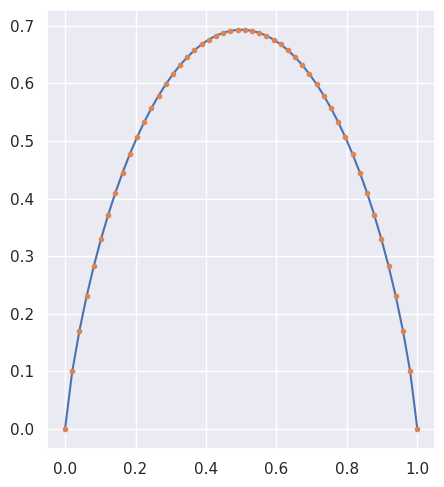

In [90]:
# Should be a symmetric function
p0 = np.linspace(0,1)
plt.plot(p0, [mean_H(1-p, p) for p in p0], '-')
plt.plot(p0, [mean_H(p, 1-p) for p in p0], ' .')

In [50]:
pos_pattern_distributions = get_all_pattern_distributions_by_cluster(pos_data, patterns, 'instruction', 'pos__B')
pos_pattern_distributions.to_csv('pos_pattern_distributions.csv')
pos_pattern_distributions.head()

col_0,False,True,pattern,cluster_col,frequency,overall_count,overall_frequency,lift,cluster_number
pos__B,,,,,,,,,
pos__B01,1224,20,cars,pos__B,0.016077,536,0.035707,0.450251,-1
pos__B02,112,23,cars,pos__B,0.170370,536,0.035707,4.771324,-1
pos__B03,384,69,cars,pos__B,0.152318,536,0.035707,4.265753,-1
pos__B04,287,2,cars,pos__B,0.006920,536,0.035707,0.193810,-1
pos__B05,391,40,cars,pos__B,0.092807,536,0.035707,2.599127,-1


In [95]:
# pos_pattern_distributions[pos_pattern_distributions['pattern']== 'cars'][False].sum()
mean_H(counts(True, 'cars'), counts(False, 'cars'))
pos_pattern_distributions[pos_pattern_distributions.pattern == 'cars'].index


Index(['pos__B01', 'pos__B02', 'pos__B03', 'pos__B04', 'pos__B05', 'pos__B06',
       'pos__B07', 'pos__B08', 'pos__B09', 'pos__B10', 'pos__B11', 'pos__B12',
       'pos__B13', 'pos__B14', 'pos__B15', 'pos__B16', 'pos__B17', 'pos__B18',
       'pos__B19', 'pos__B20', 'pos__B21', 'pos__B22', 'pos__B23', 'pos__B24',
       'pos__B25', 'pos__B26', 'pos__B27', 'pos__B28', 'pos__B29', 'pos__B30',
       'pos__B31', 'pos__B32', 'pos__B33', 'pos__B34', 'pos__B35', 'pos__B36',
       'pos__B37', 'pos__B38', 'pos__B39', 'pos__B40', 'pos__B41', 'pos__B42',
       'pos__B43', 'pos__B44', 'pos__B45', 'pos__B46', 'pos__B47', 'pos__B48',
       'pos__B49', 'pos__B50', 'pos__B51', 'pos__B52', 'pos__B53', 'pos__B54',
       'pos__B55', 'pos__B56', 'pos__B57', 'pos__B58', 'pos__B59', 'pos__B60',
       'pos__B61', 'pos__B62', 'pos__B63', 'pos__B64', 'pos__B65', 'pos__B66',
       'pos__B67', 'pos__B68', 'pos__B69', 'pos__B70', 'pos__B71', 'pos__B72',
       'pos__B73', 'pos__B74'],
      dtype='object'

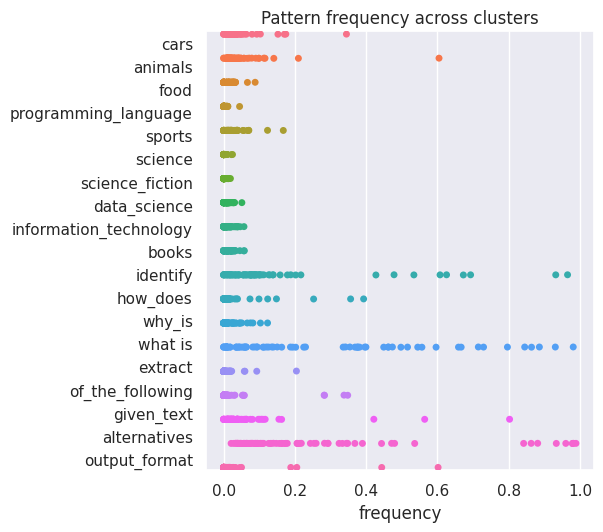

In [49]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_pattern_distribution(pos_pattern_distributions, 'frequency')

# Use k-means to get the same number of clusters

In [29]:
from sklearn.cluster import KMeans

n_clusters = 20
seed=0
semantic_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in pos_data['instruction_vector']])
pos_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in pos_data['pos_tfidf_PCs']])

pos_data['semantic_kmeans'] = semantic_kmeans.labels_
pos_data['pos_kmeans'] = pos_kmeans.labels_

/home/jma/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jma/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jma/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jma/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

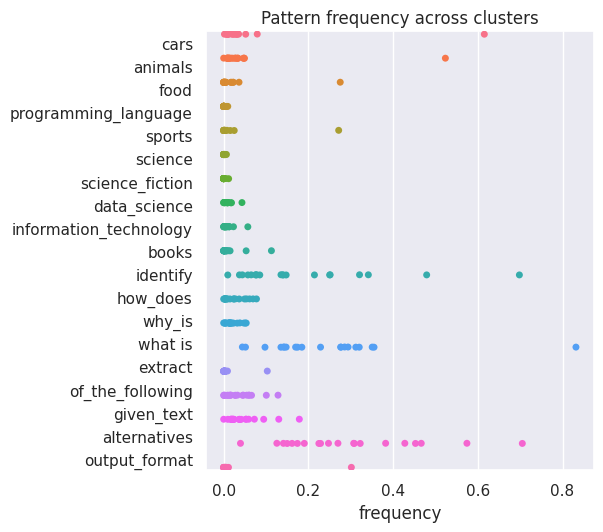

In [30]:
semantic_kmeans_pattern_distributions = get_all_pattern_distributions_by_cluster(pos_data, patterns, 'instruction', 'semantic_kmeans')
plot_pattern_distribution(semantic_kmeans_pattern_distributions, 'frequency')

/home/jma/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jma/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jma/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jma/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

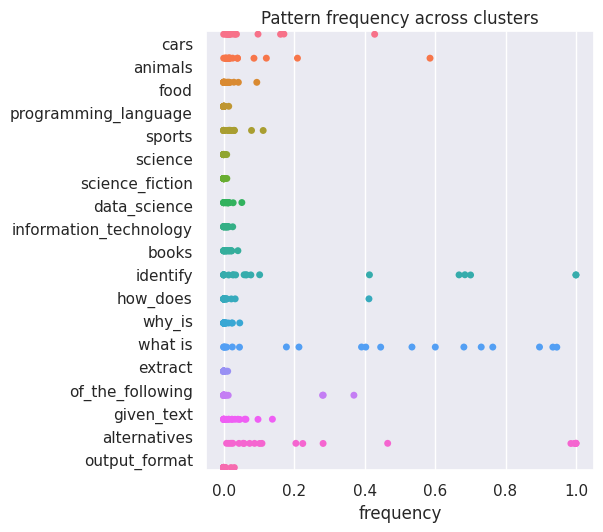

In [31]:
pos_kmeans_pattern_distributions = get_all_pattern_distributions_by_cluster(pos_data, patterns, 'instruction', 'pos_kmeans')
plot_pattern_distribution(pos_kmeans_pattern_distributions, 'frequency')

# Compare semantic clusters to POS clusters

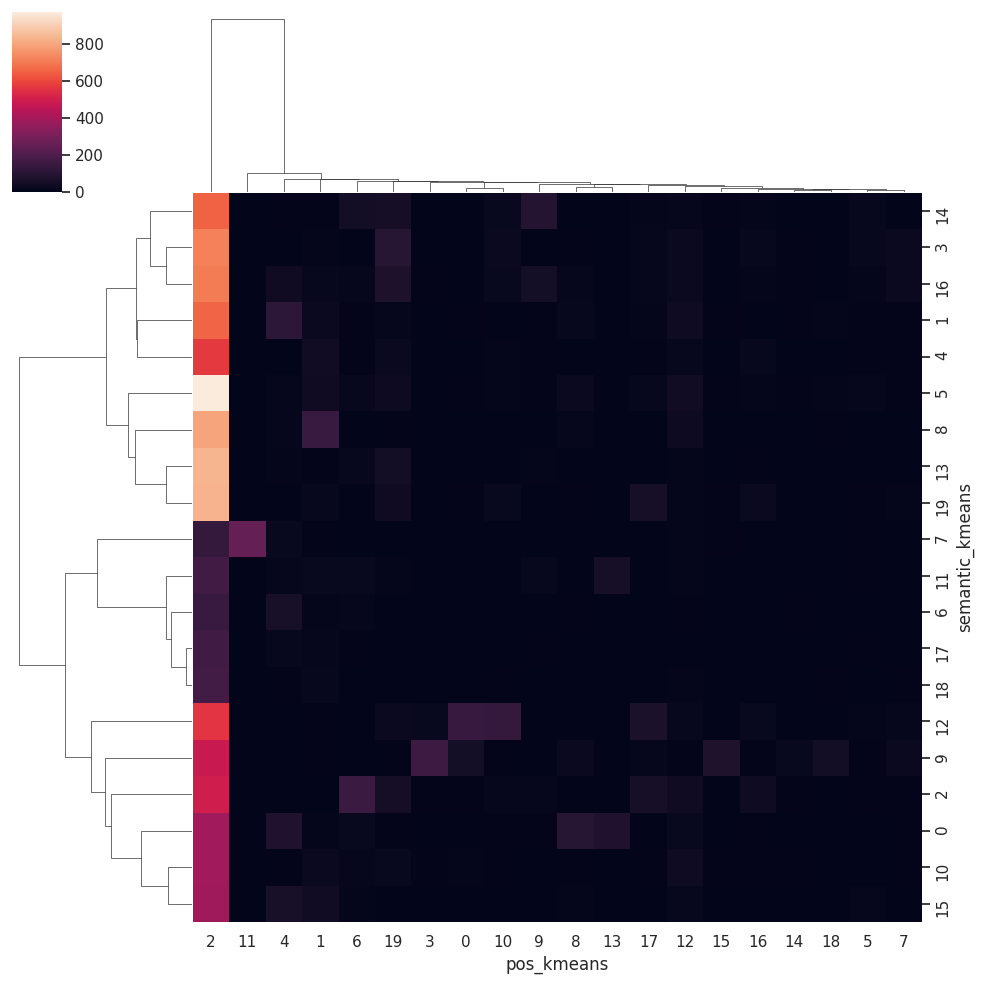

In [32]:
sem_pos_xtab = pd.crosstab(pos_data['semantic_kmeans'] , pos_data['pos_kmeans'])
sns.clustermap(sem_pos_xtab)

# To Do

Measure the spread of pattern frequency across clusters as a type of entropy (or whatever).

Show that by down-weighting the semantic vector dimensions indicative of framework aspects we get more focused distribution of domain aspects across clusters (lower entropy).